# Assessing Datasets for Rooftop Solar Technical Potential, CA Buildings, & Community Solar Potential

Author: Sofia Ingersoll

In [5]:
# loading libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr 
import rioxarray as rioxr
import rasterio 
import matplotlib.pyplot as plt
import ipyleaflet
import folium
import shapely


from ipyleaflet import GeoJSON, Map, Marker, Popup, basemap_to_tiles, basemaps, LayersControl, Marker, Popup, GeoData
from ipywidgets import HTML 

from shapely.validation import make_valid
from shapely.geometry import Polygon


# Function to convert column names to snake_case
def to_snake_case(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('\n', '_').str.lower()
    return df

## Microsoft Building Data

In [45]:
path_to_file = '../../../data/Thrust_2.1_Building_Energy_DS/building_type_data/California.geojson'
# this takes several minutes to pull in due to the volume of the data
buildings = gpd.read_file(path_to_file)

In [43]:
#------------------------------------
# ----        Check Point!       ----
#------------------------------------
# view data set
buildings = gpd.GeoDataFrame(buildings)

buildings.head(3)

# Check geospatial attributes
print(f'The CRS for the Microsoft Building Data is: {buildings.crs}')

The CRS for the Microsoft Building Data is: EPSG:4326


In [37]:
buildings.head(3)

,release,capture_dates_range,geometry
0,1,,"POLYGON ((-114.12745 34.26567, -114.12748 34.2..."
1,1,,"POLYGON ((-114.12769 34.26094, -114.12770 34.2..."
2,1,,"POLYGON ((-114.12799 34.26498, -114.12799 34.2..."


<Axes: >

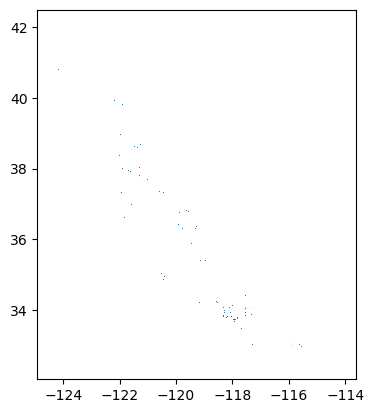

In [7]:
buildings.plot()

## Google's Project Sunroof 

In [29]:
# read in Google's Project Sunroof Data
sunroof_data_path = '../../../data/Thrust_2.1_Building_Energy_DS/rooftop_solar_potential_data/project-sunroof-census_tract.csv'

sunroof_data = pd.read_csv(sunroof_data_path)

sunroof_data.head(3)


,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,1001020100,Alabama,32.505161,32.449730,-86.475128,-86.510422,32.477184,-86.490082,1095.65,591.0,...,6.735739e+05,3.744787e+06,2.558342e+06,2.776739e+06,2.567009e+06,14854.402856,1.232045e+07,"[[0,76],[5,163],[10,136],[15,78],[20,52],[25,2...",7325.568357,0.0
1,1001020200,Alabama,32.489342,32.456120,-86.465378,-86.481270,32.474255,-86.473381,1095.65,718.0,...,1.354248e+06,4.702247e+06,2.993705e+06,2.978384e+06,6.819697e+06,13564.145190,1.884828e+07,"[[0,122],[5,200],[10,168],[15,89],[20,46],[25,...",11206.925804,0.0
2,1001020300,Alabama,32.491909,32.459209,-86.450684,-86.470871,32.475426,-86.460190,1095.65,1121.0,...,2.010001e+06,7.390340e+06,3.998881e+06,4.096211e+06,8.226100e+06,12725.930640,2.572153e+07,"[[0,167],[5,363],[10,258],[15,150],[20,61],[25...",15293.664803,1.0


In [30]:
# isolate for CA observations
sunroof_ca = sunroof_data.loc[sunroof_data['state_name'] == 'California']

In [ ]:
#------------------------------------
# ----        Check Point!       ----
#------------------------------------
# view data set
sunroof_ca.head(3)

# Check geospatial attributes
print('height: ', sunroof_ca.height)
print('width: ', sunroof_ca.width, '\n')
print(sunroof_ca.bounds(), '\n')

print(f'The CRS for the Google Project Sunroof Data is: {sunroof_ca.crs()}')

### Overlaying Microsoft Building Footprints with Project Sunroof Data
Let's see how these polygons relate, but first we need to convert the project sunroof lat/lon data into polygons!

In [38]:
#------------------------------------
# ---- Create  Sunroof Polygons  ----
#------------------------------------
# Function to create a polygon from bounding box coordinates
def create_polygon(row):
    
    return Polygon([
        (row['lng_min'], row['lat_min']),
        (row['lng_min'], row['lat_max']),
        (row['lng_max'], row['lat_max']),
        (row['lng_max'], row['lat_min']),
        # Closing the polygon
        (row['lng_min'], row['lat_min'])  
    ])


sunroof_ca.loc[:, 'geometry'] = sunroof_ca.apply(create_polygon, axis = 1)

# Convert to GeoDataFrame
sunroof_ca = gpd.GeoDataFrame(sunroof_ca, geometry='polygon', crs="EPSG:4326")

sunroof_ca.head(3)

,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count,polygon,geometry
2534,6001400100,California,37.885250,37.849960,-122.212379,-122.246674,37.867596,-122.231903,1229.958203,1045.0,...,4.225887e+06,5.626865e+06,5.968850e+06,15631.896777,2.310662e+07,"[[0,160],[5,299],[10,236],[15,128],[20,66],[25...",6299.580778,143.0,"POLYGON ((-122.24667 37.84996, -122.24667 37.8...","POLYGON ((-122.24667 37.84996, -122.24667 37.8..."
2535,6001400200,California,37.852020,37.842609,-122.241913,-122.257919,37.848171,-122.249580,1229.950000,605.0,...,9.184484e+05,2.181586e+06,3.294712e+06,10733.276013,9.592760e+06,"[[0,131],[5,269],[10,133],[15,42],[20,5],[25,3...",2615.284106,38.0,"POLYGON ((-122.25792 37.84261, -122.25792 37.8...","POLYGON ((-122.25792 37.84261, -122.25792 37.8..."
2536,6001400300,California,37.848511,37.834541,-122.243721,-122.265633,37.840599,-122.254440,1229.950000,1517.0,...,3.770743e+06,4.230930e+06,4.996662e+06,12190.040503,2.296301e+07,"[[0,271],[5,667],[10,386],[15,109],[20,27],[25...",6260.427892,51.0,"POLYGON ((-122.26563 37.83454, -122.26563 37.8...","POLYGON ((-122.26563 37.83454, -122.26563 37.8..."


### Overlaying Microsoft + Project Sunroof Buidling Data

Tech pot. ct in ++

/var/folders/n4/2w_c819n7nv4fr_mvn5wpsnc0000gn/T/ipykernel_4080/2258733355.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


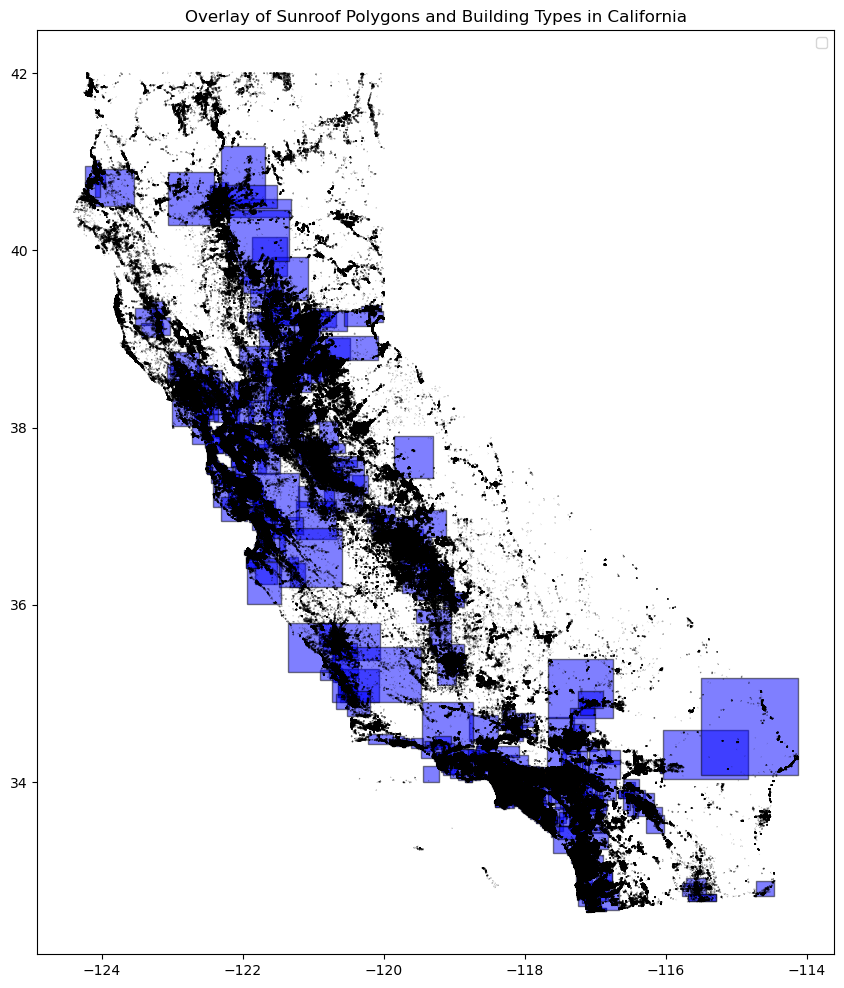

In [36]:
# Plot both datasets
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the sunroof_ca polygons
sunroof_ca.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', label='Sunroof Polygons')

# Plot the buildings dataset
buildings.plot(ax=ax, color='orange', alpha=0.5, edgecolor='k', label='Microsoft Building Footprints')

# Add legend and title
plt.legend()
plt.title('Overlay of Sunroof Polygons and Building Types in California')

# Show the plot
plt.show()

### Wrangling

The overarching goal is to identify building types with their associated techincal potential. To achieve this, I am working to remove the additional building footprints from the Microsoft data and join the two data sets using the geometry column. 

If Zillow cannot provide us with data, then here is the beginning of a potential workflow, that will likely need some supplemental data provided by ACS

- Categorize building types in accordance with small, medium, large using the area of the polygon (rooftop outline)
- Append ACS or open sourced set of Zillow neighborhood level information and pair those categorized types using the geometry, somethign along the lines of within()
- Increase the granularity back up to census tract level using GIS data for neighborhoods -> ct

**Adding Feeder Info**


Once quality feeder data has been identified, we will additionally assign feeder locations to each building / tract. If the direct infomation is not provided, Thrust Task 2.1 has reference to research that applied a roughly 7 mile buffer between a feeder and substation(s). Aggregagtion was proven to be an affective method to assess feeder load capacity and could be leveraged for this project if the direct feeder-census tract relationship data is not available

In [41]:
from shapely.validation import make_valid
from rasterio.mask import mask

# Validate and fix geometries
buildings['geometry'] = buildings['geometry'].apply(make_valid)

# Check for invalid geometries
invalid_geoms = buildings[~buildings['geometry'].is_valid]
print(f"Number of invalid geometries: {len(invalid_geoms)}")

# Simplify geometries (adjust tolerance as needed)
#buildings['geometry'] = buildings['geometry'].simplify(tolerance=0.01, preserve_topology=True)

# Check for invalid geometries again
#invalid_geoms = buildings[~buildings['geometry'].is_valid]
#print(f"Number of invalid geometries after simplification: {len(invalid_geoms)}")



/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Number of invalid geometries: 0
Number of invalid geometries after simplification: 15


In [44]:
# Ensure all geometries in sunroof_ca are valid
sunroof_ca['geometry'] = sunroof_ca['geometry'].apply(make_valid)

# Validate geometries
invalid_geoms = sunroof_ca[~sunroof_ca['geometry'].is_valid]
print(f"Number of invalid geometries: {len(invalid_geoms)}")

# Simplify geometries (adjust the tolerance as needed)
#sunroof_ca['geometry'] = sunroof_ca['geometry'].simplify(tolerance=0.01, preserve_topology=True)

# Validate again
#invalid_geoms = sunroof_ca[~sunroof_ca['geometry'].is_valid]
#print(f"Number of invalid geometries after simplification: {len(invalid_geoms)}")

Number of invalid geometries: 0


/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [46]:
# Create a bounding box of the area of interest
bbox = sunroof_ca.unary_union.envelope
bbox_polygon = gpd.GeoSeries([bbox], crs=sunroof_ca.crs)
# Ensure bbox_polygon is a GeoDataFrame
bbox_polygon = gpd.GeoDataFrame({'geometry': [bbox]}, crs=sunroof_ca.crs)

# Perform intersection
intersection_gdf = gpd.overlay(buildings, bbox_polygon, how='intersection')

# Check the result
print(intersection_gdf.head())


   release capture_dates_range  \
0        1                       
1        1                       
2        1                       
3        1                       
4        1                       

                                            geometry  
0  POLYGON ((-114.13183 34.28395, -114.13204 34.2...  
1  POLYGON ((-114.13230 34.28511, -114.13227 34.2...  
2  POLYGON ((-114.13278 34.28149, -114.13278 34.2...  
3  POLYGON ((-114.13396 34.28270, -114.13404 34.2...  
4  POLYGON ((-114.13456 34.28036, -114.13405 34.2...  


/var/folders/n4/2w_c819n7nv4fr_mvn5wpsnc0000gn/T/ipykernel_4080/2022508135.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


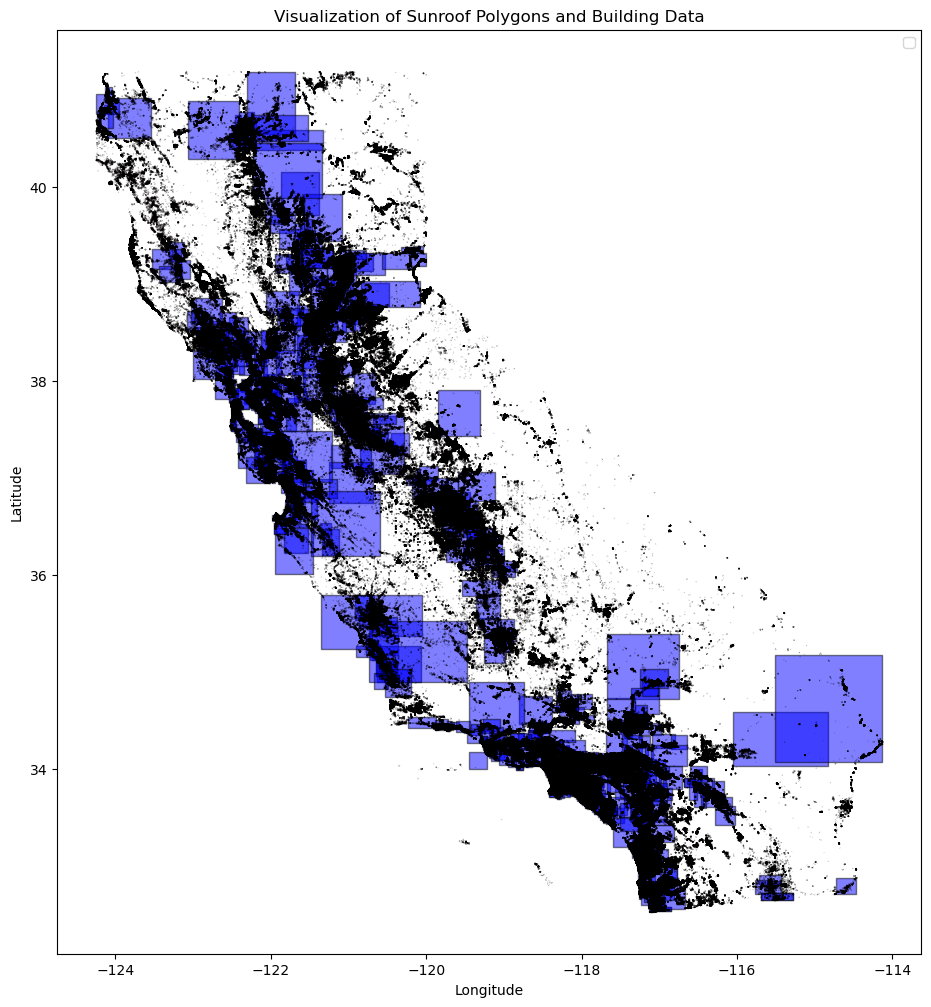

: 

In [47]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot sunroof_ca polygons
sunroof_ca.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', label='Sunroof Polygons')

# Plot buildings clipped or intersected data
intersection_gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Building Data')

# Add legend and title
plt.legend()
plt.title('Visualization of Sunroof Polygons and Building Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
import rasterio
from rasterio.mask import mask

# Load raster data (ensure you have a compatible raster format)
with rasterio.open('path_to_raster_file.tif') as src:
    out_image, out_transform = mask(src, [bbox_polygon.unary_union], crop=True)

# Save the clipped raster
with rasterio.open('path_to_clipped_raster.tif', 'w', **src.meta) as dst:
    dst.write(out_image)


In [ ]:
# Ensure the geometry column is set correctly
buildings_clipped = gpd.GeoDataFrame(buildings_clipped, geometry='geometry', crs=sunroof_ca.crs)

# Spatial join: Combine the datasets based on spatial overlap
joined_gdf = gpd.sjoin(sunroof_ca, buildings_clipped, how="inner", op='intersects')

# Check the result
joined_gdf.head(3)

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot sunroof_ca polygons
sunroof_ca.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', label='Sunroof Polygons')

# Plot buildings clipped data
buildings_clipped.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Building Data')

# Add legend and title
plt.legend()
plt.title('Visualization of Sunroof Polygons and Building Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Global Horizontal Irradiance Annual GHI 2018, NREL

In [9]:
import rasterio

In [12]:
ghi_path = '../../../rooftop_solar_potential_data/nsrdbv3_ghi/Annual GHI/nsrdb3_ghi.tif'

ghi = rasterio.open(ghi_path)

ghi

# selecting the initial layer
array = ghi.read(1)

array.shape

(2025, 3940)

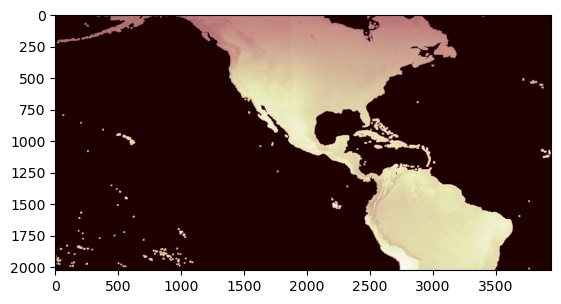

In [14]:
from matplotlib import pyplot

pyplot.imshow(array, cmap='pink')

pyplot.show()  

## Annual Technology Baseline